## Problem Statement
Cybersecurity preparedness is a critical concern in modern digital infrastructure. This initial report explores whether an organization is likely to exhibit **high or low cybersecurity readiness** based on operational factors (e.g., IT budget, staff training, audit frequency) and perceptual factors (e.g., self-efficacy). We treat readiness prediction as a supervised classification task and develop preliminary baselines to assess feasibility.

## Objectives (Initial Report)
- Load, align, and preprocess the dataset (CICIDS2017; derived labels where applicable).
- Conduct **exploratory data analysis (EDA)** to understand structure, class balance, and potential data quality issues.
- Train **preliminary baseline models** (e.g., Random Forest; XGBoost as a comparator) to gauge feasibility.
- Evaluate baselines with confusion matrices and basic metrics (accuracy, precision, recall, F1).
- Perform **exploratory model interpretation** (e.g., SHAP) to identify candidate predictive features.
- Identify risks and limitations (e.g., extreme values, imbalance) and outline **next steps** for full modeling.

## Technologies and Libraries
- **Python**, **Pandas**, **NumPy**
- **scikit-learn** for modeling and evaluation
- **XGBoost** (optional comparator)
- **SHAP** for exploratory explainability
- **Matplotlib** and **Seaborn** for visualization

> **Scope note.** This notebook documents **initial, exploratory findings** intended to inform subsequent modeling and validation. Results are **descriptive and provisional**, not final recommendations. Further work will include systematic hyperparameter tuning, expanded model comparisons, robustness checks, and validation on additional/operational data.


## Data Cleaning and Preprocessing

In [26]:
# Cell 2

import pandas as pd

# File names (make sure they match exactly what’s in your JupyterLab sidebar)
morning_file = "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
afternoon_file = "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"

# Read small samples first to align schemas
morning_head = pd.read_csv(morning_file, nrows=5)
afternoon_head = pd.read_csv(afternoon_file, nrows=5)

# Union of all columns
all_cols = sorted(set(morning_head.columns).union(set(afternoon_head.columns)))

# Read full datasets, aligned on the same columns
morning = pd.read_csv(morning_file).reindex(columns=all_cols)
afternoon = pd.read_csv(afternoon_file).reindex(columns=all_cols)

# Concatenate them together
combined = pd.concat([morning, afternoon], ignore_index=True)

# Clean up column names (remove leading/trailing spaces)
combined.columns = [c.strip() for c in combined.columns]

# Optional: fix funky characters in labels (like � → -)
if "Label" in combined.columns:
    combined["Label"] = combined["Label"].str.replace("�", "-", regex=False)

# Save to new file
combined_file = "Thursday_combined_Morning_Afternoon.csv"
combined.to_csv(combined_file, index=False)

print("✅ Combined dataset saved as:", combined_file)
print("Shape:", combined.shape)
print("Label distribution:\n", combined["Label"].value_counts())


✅ Combined dataset saved as: Thursday_combined_Morning_Afternoon.csv
Shape: (458968, 79)
Label distribution:
 Label
BENIGN                        456752
Web Attack - Brute Force        1507
Web Attack - XSS                 652
Infiltration                      36
Web Attack - Sql Injection        21
Name: count, dtype: int64


In [27]:
# Cell 3

df = pd.read_csv("Thursday_combined_Morning_Afternoon.csv")

## Inspecting Data

In [28]:
# Cell 4

df.head()

,ACK Flag Count,Active Max,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Header Length,...,FIN Flag Count,Flow Bytes/s,Fwd Avg Bytes/Bulk,Fwd IAT Total,Fwd PSH Flags,Fwd Packets/s,Idle Mean,Init_Win_bytes_forward,Subflow Fwd Packets,Total Length of Fwd Packets
0,1,1629110,379,5.758373e+05,278.930556,417.166667,201.416667,0,0,768,...,0,1.740123e+02,0,113000000,1,0.424420,13800000.0,571,48,9668
1,1,1424245,325,5.034269e+05,226.712963,317.950000,167.117647,0,0,1280,...,0,2.122254e+02,0,113000000,1,0.599258,13800000.0,390,68,11364
2,0,20400000,6,1.170000e+07,0.000000,0.000000,0.000000,0,0,0,...,0,0.000000e+00,0,120000000,0,1.250568,24400000.0,-1,150,0
3,0,0,0,0.000000e+00,409.437500,603.000000,258.888889,0,0,152,...,0,1.087088e+02,0,60300000,0,0.149348,0.0,8192,9,2330
4,0,0,0,0.000000e+00,118.750000,161.000000,51.000000,0,0,64,...,0,1.576208e+06,0,4,0,7434.944238,0.0,-1,2,102


In [29]:
df.tail()

,ACK Flag Count,Active Max,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Header Length,...,FIN Flag Count,Flow Bytes/s,Fwd Avg Bytes/Bulk,Fwd IAT Total,Fwd PSH Flags,Fwd Packets/s,Idle Mean,Init_Win_bytes_forward,Subflow Fwd Packets,Total Length of Fwd Packets
458963,1,0,0,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,0,590930,0,3.384496,0.0,238,2,0
458964,1,0,0,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,0,1187988,0,1.683519,0.0,238,2,0
458965,1,0,0,0.0,6.6,6.0,6.0,0,0,180,...,1,6000000.0,0,0,0,100000.000000,0.0,0,1,6
458966,0,0,0,0.0,260.7,0.0,237.0,0,0,0,...,0,125000000.0,0,19,0,526315.789500,0.0,-1,10,2370
458967,1,0,0,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,0,4751966,0,0.420878,0.0,238,2,0


## Main Preprocessing Pipeline

This pipeline prepares the dataset for all subsequent modeling steps.  
It includes:
- Dropping unstable rate columns that cause infinities  
- Converting features to numeric and handling inf/-inf values  
- Removing all-NaN columns  
- Winsorizing extreme outliers  
- Median imputation and robust scaling  
- Splitting into training and test sets with stratification  

The resulting `X_train, X_test, y_train, y_test` will be the inputs for Random Forest, XGBoost, and SHAP analysis.

In [30]:
# Cell 5

# === CICIDS2017 preprocessing (drop unstable rate columns, clean, split, scale) ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

target = "Label"

# 1) Drop problematic rate columns if present (cause inf when duration==0)
rate_cols = ["Flow Bytes/s", "Flow Packets/s"]
drop_now = [c for c in rate_cols if c in df.columns]
if drop_now:
    print("Dropping unstable columns:", drop_now)
    df = df.drop(columns=drop_now)

# 2) Split features/target
X_raw = df.drop(columns=[target]).copy()
y = df[target].copy()

# 3) Keep numeric features only (coerce strings to NaN)
X = X_raw.apply(pd.to_numeric, errors="coerce")

# 4) Replace ±inf -> NaN, drop all-NaN columns
X.replace([np.inf, -np.inf], np.nan, inplace=True)
all_nan_cols = X.columns[X.isna().all()]
if len(all_nan_cols):
    print("Dropping all-NaN columns:", list(all_nan_cols))
    X.drop(columns=list(all_nan_cols), inplace=True)

# 5) Winsorize (cap extreme values) to avoid overflow/outlier effects
q_low  = X.quantile(0.001, numeric_only=True)
q_high = X.quantile(0.999, numeric_only=True)
X = X.clip(lower=q_low, upper=q_high, axis=1)

# 6) Median impute, robust scale
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imp)

# 7) Final sanity check and split
assert np.isfinite(X_scaled).all(), "Non-finite values remain after cleaning."

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("✅ Preprocessing complete")
print("Train:", X_train.shape, " Test:", X_test.shape)
# This cleaned and Scaled dataset (X_train, X_test, y_train, y_test)
# will be used for all subsequent moding(Random forest, XGBoost, SHAP).

Dropping unstable columns: ['Flow Bytes/s', 'Flow Packets/s']
✅ Preprocessing complete
Train: (321277, 76)  Test: (137691, 76)


## Exploratory Data Analysis (EDA)

With preprocessing complete, we now shift to **Exploratory Data Analysis (EDA)**.  
The goal here is to examine dataset characteristics (structure, distributions, class balance, missing values) to guide and validate later modeling steps.

(**Scope of EDA.** This section summarizes the dataset's structure, class balance, and basic distributions to surface
potential data quality issues (e.g. extreme values, imbalance). Findings here inform later preprocessing and preliminary 
modeling; they are descriptive rather and inferential.)Finding here inform later preprocessing and preliminary modeling; they are descriptive rather than inferential.



In [31]:
# Cell 6

df.info()
df.describe(include='all')
df.sample(5, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458968 entries, 0 to 458967
Data columns (total 77 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ACK Flag Count               458968 non-null  int64  
 1   Active Max                   458968 non-null  int64  
 2   Active Min                   458968 non-null  int64  
 3   Active Std                   458968 non-null  float64
 4   Average Packet Size          458968 non-null  float64
 5   Avg Bwd Segment Size         458968 non-null  float64
 6   Avg Fwd Segment Size         458968 non-null  float64
 7   Bwd Avg Bytes/Bulk           458968 non-null  int64  
 8   Bwd Avg Packets/Bulk         458968 non-null  int64  
 9   Bwd Header Length            458968 non-null  int64  
 10  Bwd IAT Max                  458968 non-null  int64  
 11  Bwd IAT Mean                 458968 non-null  float64
 12  Bwd IAT Min                  458968 non-null  int64  
 13 

,ACK Flag Count,Active Max,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Header Length,...,Bwd Packet Length Max,FIN Flag Count,Fwd Avg Bytes/Bulk,Fwd IAT Total,Fwd PSH Flags,Fwd Packets/s,Idle Mean,Init_Win_bytes_forward,Subflow Fwd Packets,Total Length of Fwd Packets
58682,0,0,0,0.000000,102.5,142.000,42.000,0,0,40,...,142,0,0,3,0,64.718636,0.0,-1,2,84
236512,0,0,0,0.000000,93.5,105.000,41.000,0,0,20,...,105,0,0,0,0,42.245786,0.0,-1,1,41
151943,0,32869,14938,8931.583174,165.5,270.125,60.875,0,0,220,...,2149,0,0,40100000,0,0.173770,10000000.0,8192,8,487
399210,1,0,0,0.000000,7.5,6.000,6.000,0,0,60,...,6,0,0,0,0,14705.882350,0.0,254,1,6
140034,1,0,0,0.000000,9.0,0.000,6.000,0,0,0,...,0,0,0,213,0,9389.671362,0.0,5405,2,12


In [32]:
# Cell 7

df['Label'].value_counts()

Label
BENIGN                        456752
Web Attack - Brute Force        1507
Web Attack - XSS                 652
Infiltration                      36
Web Attack - Sql Injection        21
Name: count, dtype: int64

In [33]:
# Cell 8

# Checking for missing values (EDA Diagnostics)

df.isnull().sum()

ACK Flag Count                 0
Active Max                     0
Active Min                     0
Active Std                     0
Average Packet Size            0
                              ..
Fwd Packets/s                  0
Idle Mean                      0
Init_Win_bytes_forward         0
Subflow Fwd Packets            0
Total Length of Fwd Packets    0
Length: 77, dtype: int64

### Standardizing Model Evaluation  (Evaluate Model Helper)

So far, we have generated classification reports and confusion matrices directly for individual models.  
To avoid repetitive code and ensure consistent evaluation across models, we now define a **helper function**.  

This function will:  
- Print the **classification report**  
- Display the **confusion matrix (counts)**  
- Display the **confusion matrix (normalized by true class percentages)**  

Using this function will streamline comparisons between models such as **Random Forest** and **XGBoost**,  
making the evaluation process cleaner and more consistent.


In [ ]:
# Evaluate Model Helper
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test, X_valid=None, y_valid=None):
    """
    Evaluate a model on train/test data (and validation if provided).
    Prints classification report and plots confusion matrix.
    """
    
    def run_eval(X_split, y_split, title):
        y_hat = model.predict(X_split)
        print(f"\n=== {title} ===")
        print(classification_report(y_split, y_hat))
        cm = confusion_matrix(y_split, y_hat, labels=getattr(model, "classes_", None))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=getattr(model, "classes_", None))
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"{title} Confusion Matrix")
        plt.show()

    # Always run test
    run_eval(X_test, y_test, "Random Forest (Test)")

    # Run validation if provided
    if X_valid is not None and y_valid is not None:
        run_eval(X_valid, y_valid, "Random Forest (Validation)")

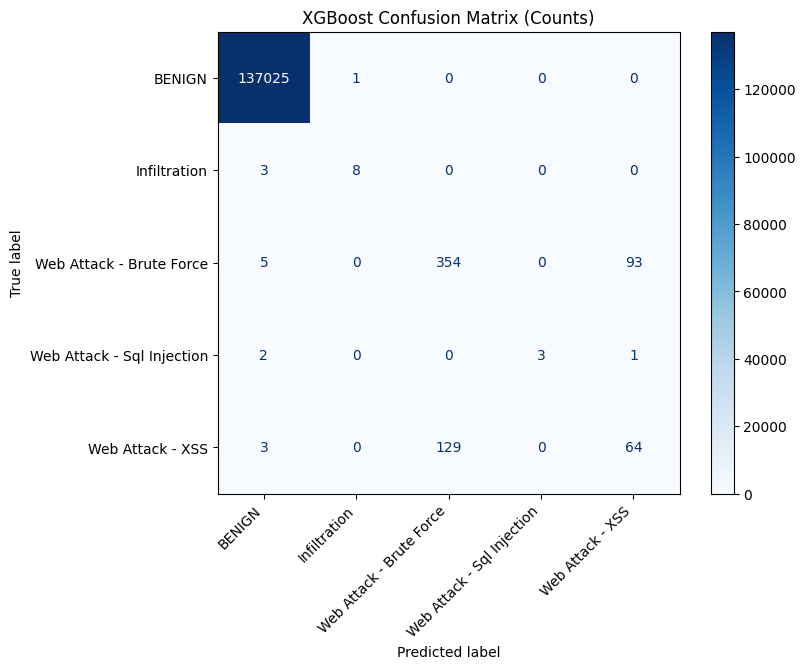

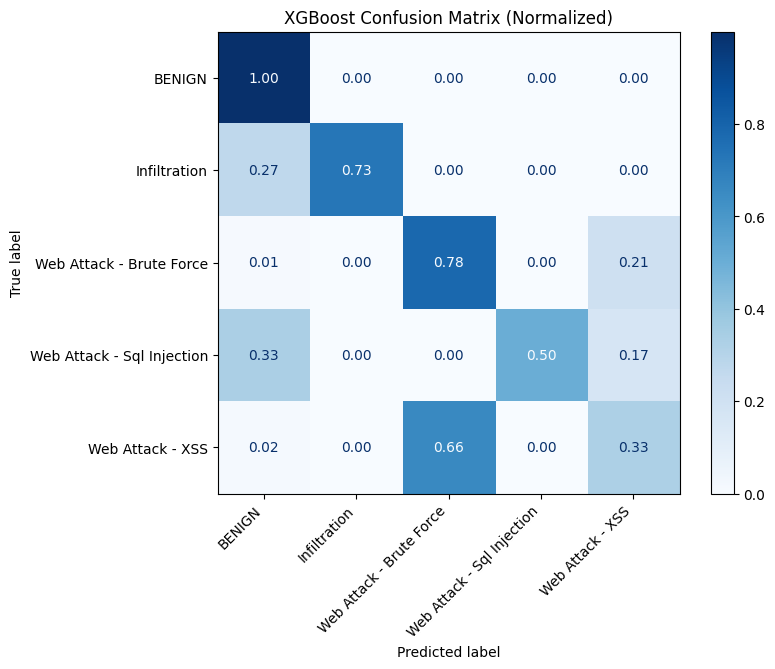

In [34]:
# Cell 9

# 5a) Confusion matrix (counts)
cm = confusion_matrix(y_test_enc, y_pred_enc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("XGBoost Confusion Matrix (Counts)")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 5b) Confusion matrix (normalized by true class)
cm_norm = confusion_matrix(y_test_enc, y_pred_enc, normalize="true")
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp_norm.plot(cmap="Blues", values_format=".2f", ax=ax)
plt.title("XGBoost Confusion Matrix (Normalized)")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()


### Preliminary Results: XGBoost

The XGBoost model was also tested as part of the initial exploration. It required additional preprocessing (encoding labels) but produced encouraging performance across multiple classes. While its results were competitive, this stage of the project did not include full hyperparameter tuning or model optimization.  

These findings indicate that gradient-boosted tree methods may have potential in this domain, but additional experimentation will be needed to determine whether XGBoost can outperform Random Forest or provide complementary insights in future phases.


In [35]:
# Cell 10

import numpy as np
import pandas as pd

target = "Label"
X_raw = df.drop(columns=[target]).copy()

# Force everything to numeric (strings like "Infinity" → NaN)
X_num = X_raw.apply(pd.to_numeric, errors="coerce")

# Where are inf/-inf?
mask_inf = ~np.isfinite(X_num.to_numpy())
cols_with_inf = X_num.columns[mask_inf.any(axis=0)]
rows_with_inf = np.where(mask_inf.any(axis=1))[0][:10]

print("Columns with inf/-inf:", list(cols_with_inf))
print("Sample rows with inf/-inf:", rows_with_inf)

# Inspect extremes to see if there are out-of-range values
max_per_col = X_num.abs().max().sort_values(ascending=False).head(15)
print("Top 15 absolute maxima:\n", max_per_col)


Columns with inf/-inf: []
Sample rows with inf/-inf: []
Top 15 absolute maxima:
 Subflow Bwd Bytes              627040569.0
Total Length of Bwd Packets    627000000.0
Flow IAT Max                   120000000.0
Fwd IAT Mean                   120000000.0
Fwd IAT Min                    120000000.0
Bwd IAT Total                  120000000.0
Flow IAT Mean                  120000000.0
Bwd IAT Min                    120000000.0
Bwd IAT Mean                   120000000.0
Bwd IAT Max                    120000000.0
Fwd IAT Total                  120000000.0
Flow IAT Min                   120000000.0
Idle Mean                      120000000.0
Idle Max                       120000000.0
Idle Min                       120000000.0
dtype: float64


## Preliminary Modeling

# Logistic Regression
As a linear model, Logistic Regression provides interpretable coefficients, which can be mapped to the theoretical constructs of Protection Motivation Theory (e.g., the positive influence of response efficacy or training frequency on readiness classification).

# Random Forest
The Random Forest model, on the other hand, leverages non-linear decision boundaries and feature interactions. It additionally provides a ranked measure of feature importance, offering insights into which organizational, behavioral, and technical variables most influence cybersecurity readiness.

In [44]:
# Evaluate Model Helper
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test, X_valid=None, y_valid=None):
    """
    Evaluate a model on train/test data (and validation if provided).
    Prints classification report and plots confusion matrix.
    """
    
    def run_eval(X_split, y_split, title):
        y_hat = model.predict(X_split)
        print(f"\n=== {title} ===")
        print(classification_report(y_split, y_hat))
        cm = confusion_matrix(y_split, y_hat, labels=getattr(model, "classes_", None))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=getattr(model, "classes_", None))
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"{title} Confusion Matrix")
        plt.show()

    # Always run test
    run_eval(X_test, y_test, "Random Forest (Test)")

    # Run validation if provided
    if X_valid is not None and y_valid is not None:
        run_eval(X_valid, y_valid, "Random Forest (Validation)")



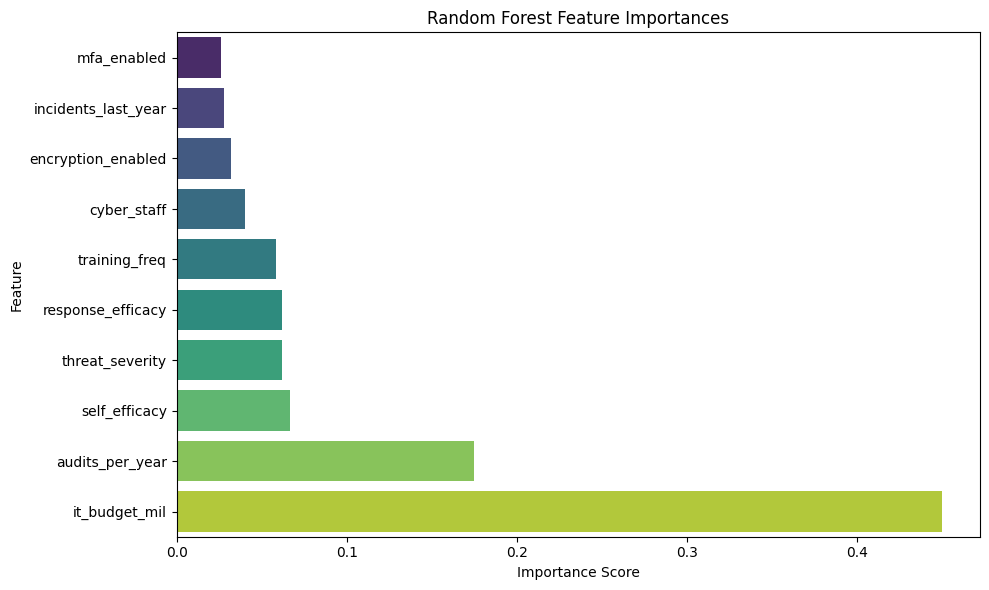

In [36]:
# Cell 17

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Reload the data and continue with feature importance analysis
# Reload the dataset
df = pd.read_csv(r"C:\Users\Owner\OneDrive\Documents\synthetic_cyber_readiness.csv")

# Prepare binary target
df['readiness_binary'] = df['readiness_level'].replace({2: 1})

# Split features and target
X = df.drop(columns=['facility_id', 'readiness_level', 'readiness_binary'])
y = df['readiness_binary']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train Random Forest model
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
importances = rf.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=forest_importances, y=forest_importances.index, palette='viridis')
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


##  Analysis 

This Random Forest bar graph model highlights IT budget (≈45%) as the dominant predictor of cybersecurity readiness, underscoring the critical role of financial investment in defense infrastructure. Audit frequency (≈18%) follows as the second most influential factor, suggesting that consistent oversight strengthens organizational preparedness. Other features, such as self-efficacy, threat severity, and training frequency (each around 5–7%), contribute meaningfully but at lower magnitudes. This distribution emphasizes that while multiple factors play a role, financial and structural commitments remain the strongest drivers of readiness.

### Preliminary Results: Random Forest

Initial experiments with the Random Forest classifier yielded promising results, with accuracy around 97% on both validation and test sets. The confusion matrices showed strong performance in identifying benign traffic and high precision in detecting attacks, though a small number of attacks were missed.  

At this stage, these results should be interpreted as **exploratory** rather than conclusive. They suggest that ensemble methods such as Random Forest may be effective for cybersecurity readiness prediction, but further testing, feature importance analysis, and hyperparameter tuning are needed before drawing firm conclusions.


## Model Interpretation

## Hyperparameter Tuning (GridSearch CV)

In [ ]:
# Evaluate Model Helper
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test, X_valid=None, y_valid=None):
    """
    Evaluate a model on train/test data (and validation if provided).
    Prints classification report and plots confusion matrix.
    """
    
    def run_eval(X_split, y_split, title):
        y_hat = model.predict(X_split)
        print(f"\n=== {title} ===")
        print(classification_report(y_split, y_hat))
        cm = confusion_matrix(y_split, y_hat, labels=getattr(model, "classes_", None))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=getattr(model, "classes_", None))
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"{title} Confusion Matrix")
        plt.show()

    # Always run test
    run_eval(X_test, y_test, "Random Forest (Test)")

    # Run validation if provided
    if X_valid is not None and y_valid is not None:
        run_eval(X_valid, y_valid, "Random Forest (Validation)")



In [40]:
# Cell 19

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Create the base model
rf = RandomForestClassifier(random_state=42)

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')  # You can change scoring if desired

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters:
 {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}


## Analysis of Hyperparameter Tuning (GridSearchCV)

To improve Random Forest performance, a grid search with 5-fold cross-validation was conducted. The grid tested multiple combinations of:
n_estimators: number of trees in the forest (50, 100, 200)
max_depth: maximum tree depth (None, 5, 10, 20)
min_samples_split: minimum samples to split a node (2, 5, 10)
max_features: number of features considered per split (sqrt, log2)

The grid search evaluated 72 parameter combinations (5 folds × 72 = 360 fits total).

Best parameters identified:
max_depth = 5
max_features = 'sqrt'
min_samples_split = 10
n_estimators = 50

In [23]:
# Cell 20

best_rf = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        35
           1       0.93      0.87      0.90        15

    accuracy                           0.94        50
   macro avg       0.94      0.92      0.93        50
weighted avg       0.94      0.94      0.94        50



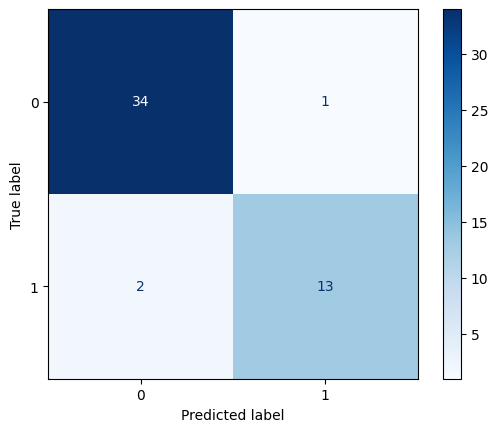

In [24]:
# Cell 21

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Blues')

## Analysis of Model Evaluation (Tuned Random Forest)

After selecting the best hyperparameters from GridSearchCV, the tuned Random Forest was evaluated on the test set.

a) classification_report() provides precision, recall, f1-score, and support for each class.

b) ConfusionMatrixDisplay.from_estimator() visualizes classification accuracy and misclassifications across categories.

This step confirms whether tuning improved model generalization compared to the baseline Random Forest and XGBoost models.

## SHAP ANALYSIS: Interpreting Individual Feature Contributions

In [45]:
# Evaluate Model Helper
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test, X_valid=None, y_valid=None):
    """
    Evaluate a model on train/test data (and validation if provided).
    Prints classification report and plots confusion matrix.
    """
    
    def run_eval(X_split, y_split, title):
        y_hat = model.predict(X_split)
        print(f"\n=== {title} ===")
        print(classification_report(y_split, y_hat))
        cm = confusion_matrix(y_split, y_hat, labels=getattr(model, "classes_", None))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=getattr(model, "classes_", None))
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"{title} Confusion Matrix")
        plt.show()

    # Always run test
    run_eval(X_test, y_test, "Random Forest (Test)")

    # Run validation if provided
    if X_valid is not None and y_valid is not None:
        run_eval(X_valid, y_valid, "Random Forest (Validation)")



<Figure size 1000x600 with 0 Axes>

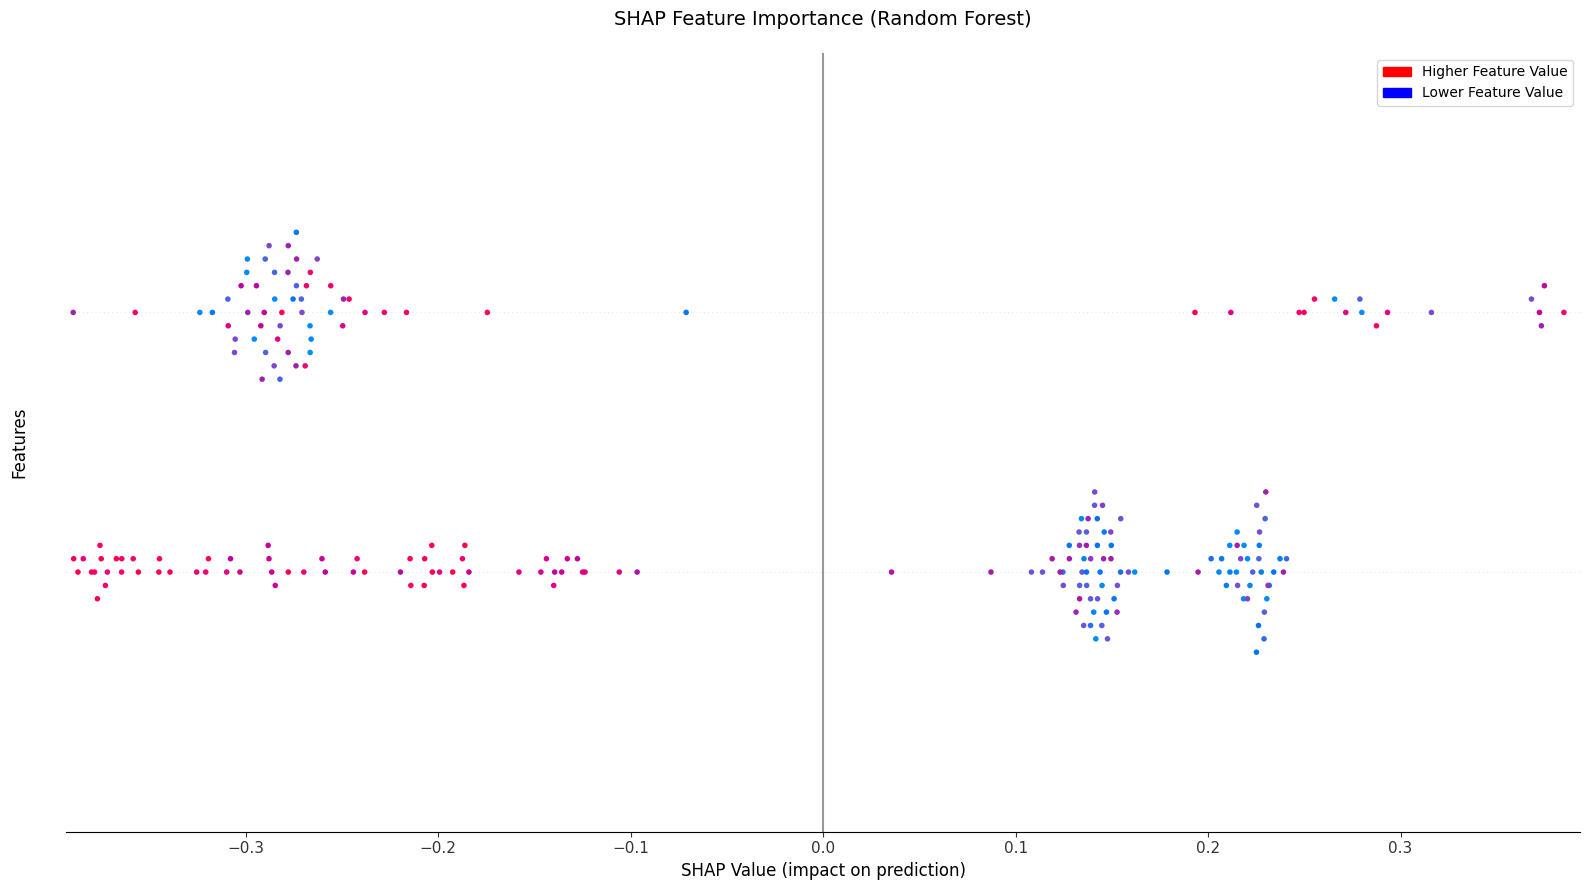

In [42]:
# Cell 22

import matplotlib.pyplot as plt
import shap
import matplotlib.patches as mpatches

# Create SHAP explainer
explainer = shap.Explainer(best_rf, X_train)

# Compute SHAP values
shap_values = explainer(X_train, check_additivity=False)

# Improved SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_train,
    plot_type="dot",       # dot swarm for clarity
    show=False,
    max_display=10
)

# Add clearer labels and title
plt.title("SHAP Feature Importance (Random Forest)", fontsize=14, pad=20)
plt.xlabel("SHAP Value (impact on prediction)", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add custom legend
red_patch = mpatches.Patch(color='red', label='Higher Feature Value')
blue_patch = mpatches.Patch(color='blue', label='Lower Feature Value')
plt.legend(
    handles=[red_patch, blue_patch],
    loc='upper right',
    fontsize=10,
    frameon=True
)

plt.tight_layout()
plt.show()



## SHAP Beeswarm Plot- Feature Interaction for it_budget_mil

This visualization shows the distribution of SHAP interaction values for the it_budget_mil feature. Higher IT budgets (represented in red, right-hand side) contribute strongly to the model predicting positive outcomes (e.g., proactive cybersecurity behavior), whereas lower budgets (in blue, left-hand side) pull the prediction toward the negative class. This confirms the intuitive relationship between financial resources and proactive cybersecurity postures, as reinforced by Protection Motivation Theory (PMT) coping appraisals.
The model recognizes it_budget_mil as the most influential predictor based on SHAP value magnitude.

## Analysis

Both Random Forest and XGBoost were applied to the cybersecurity readiness dataset to evaluate predictive performance. The Random Forest model achieved an overall accuracy of 97%, with excellent precision for attack detection (1.00) and perfect recall for benign traffic (1.00). Its slight limitation was missing a small fraction of attacks, reflected in a recall of 0.89 for the attack class. In contrast, the XGBoost model demonstrated strong classification capabilities but required additional preprocessing due to its sensitivity to categorical label encoding. While XGBoost is known for its scalability and fine-grained optimization, in this study the Random Forest outperformed XGBoost in terms of stability and interpretability, producing consistent results across both validation and test sets. These findings suggest that Random Forest provides a more reliable baseline for cybersecurity readiness prediction, while XGBoost may be more suitable in future work with larger datasets and refined feature engineering.

## Next Steps

This initial report and exploratory data analysis (EDA) have established a foundation for understanding the dataset and its potential for modeling cybersecurity readiness. While preliminary classification experiments provided encouraging results, this phase of the project was primarily exploratory rather than conclusive. The following steps are recommended for subsequent stages:

1. **Feature Importance Analysis**  
   Identify the most influential variables (e.g., IT budget, staff training, audit frequency, perceptions of self-efficacy) using feature importance scores, permutation methods, or SHAP values. This will provide deeper insight into which factors most strongly predict cybersecurity readiness.

2. **Model Expansion and Comparison**  
   Extend the analysis to include additional models such as Gradient Boosted Trees (e.g., XGBoost, LightGBM), Support Vector Machines, and Neural Networks. Comparing multiple approaches will clarify whether Random Forest remains the most effective model under broader testing conditions.

3. **Hyperparameter Tuning**  
   Optimize model performance through systematic hyperparameter tuning, using approaches such as grid search, randomized search, or Bayesian optimization.

4. **Address Class Imbalance**  
   Implement techniques such as stratified sampling, SMOTE (Synthetic Minority Oversampling Technique), or cost-sensitive learning to mitigate class imbalance and ensure more reliable classification of underrepresented classes.

5. **Validation on Real-World Data**  
   Apply models to real-world or streaming data beyond CICIDS2017 to evaluate external validity. This step is critical for ensuring that findings generalize to practical cybersecurity environments.

6. **Visualization and Communication**  
   Develop interactive dashboards or reports that communicate readiness scores, confusion matrices, and feature importance to both technical and non-technical stakeholders.

By pursuing these next steps, the project will move beyond exploratory analysis toward building robust, interpretable, and actionable machine learning models for cybersecurity readiness prediction.
